# Figures

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors, lines, style
from astropy.io import fits
import myutils
import quasar_galaxy_fit
style.use('./style.mplstyle')

## Fig. 1 - Colour Cuts in DES/WISE

Showing "traditional" DES/WISE colour cuts and known quasars and brown dwarfs.
My cuts are 
$$
\mathrm{i}-\mathrm{z} > 1 \text{ (AB)};\quad
\mathrm{W1} - \mathrm{W2} > 0.5 \text{ (Vega)}
$$

In [9]:
hzq_df = pd.read_csv('./data/external/known_hzqs.csv') # 11 objects

hzq_df['i-z'] = hzq_df['MAG_APER_4_I'] - hzq_df['MAG_APER_4_Z']
hzq_df['i-z_err'] = np.sqrt(
    hzq_df['MAGERR_APER_4_I']**2 + hzq_df['MAGERR_APER_4_Z']**2
)

# hzq_df['W1-W2_vg'] = (hzq_df['W1mag']-2.699) - (hzq_df['W2mag']-3.339)
hzq_df['W1-W2_vg'] = hzq_df['W1mag']-hzq_df['W2mag']
hzq_df['W1-W2_err'] = np.sqrt(
    hzq_df['e_W1mag']**2 + hzq_df['e_W2mag']**2
)

qso_track = pd.read_csv(
    './data/external/qso_tracks.txt',
    skiprows=4, delim_whitespace=True
)[['redshift','i-z','W1-W2']]

dwarfs_df = pd.read_csv('./data/processed/dwarfs_wise_des.csv')
dwarfs_df['i-z'] = dwarfs_df['imag'] - dwarfs_df['zmag']

tile_stars = pd.read_csv('./data/processed/three_tiles_stars_deswisevhs.csv')
tile_stars['i-z'] = tile_stars['MAG_APER_4_I'] - tile_stars['MAG_APER_4_Z']
tile_stars['W1-W2'] = 22.5 - 2.5*np.log10(
    tile_stars['FW1lbs']
) - (22.5 - 2.5*np.log10(
    tile_stars['FW2lbs']
))


/data/ajnb3/my_conda/envs/qso/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


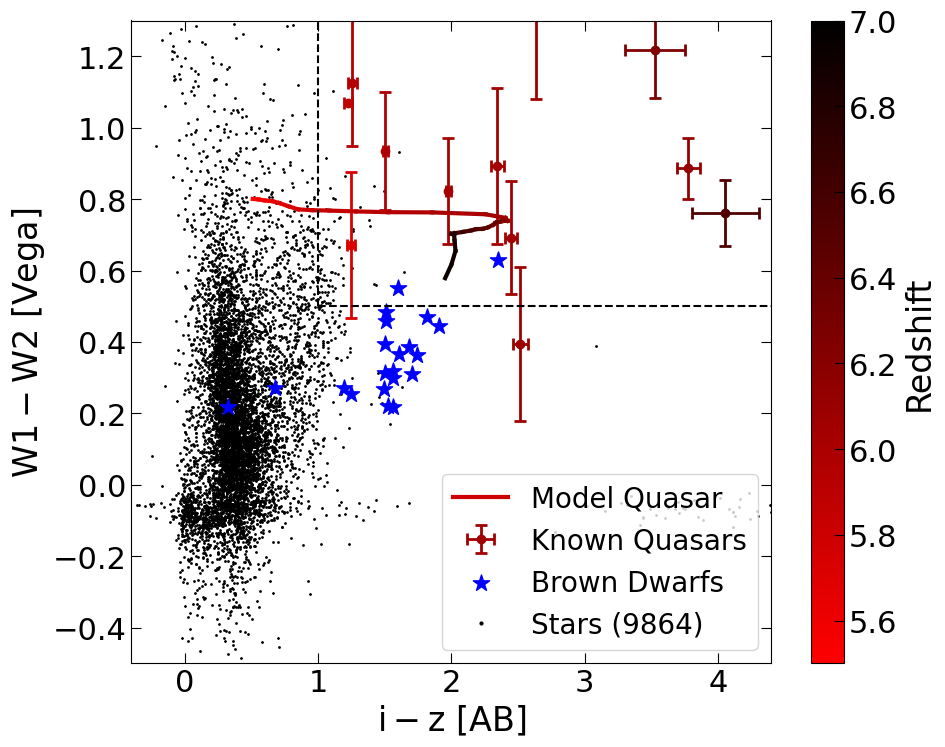

In [11]:
fg, ax = plt.subplots(figsize=(10,8))

# Plotting stars from DES tiles
star_sc = ax.scatter(
    tile_stars['i-z'], tile_stars['W1-W2'],
    c='k', s=1
)

# Plotting dwarfs
dwf_sc = ax.scatter(
    dwarfs_df['i-z'], dwarfs_df['W1-W2'],
    marker='*',c='b',s=150,
    label='Brown Dwarfs'
)

# Plotting known HZQs
def redshift_colour(z):
    "Colours a shade of red between z=5.5 and z=7.0"
    return np.array([1-(z-5.5)/1.5, 0,0,1])

for i, row in hzq_df.iterrows():
    col = redshift_colour(row['redshift'])
    hzq_eb = ax.errorbar(
        row['i-z'], row['W1-W2_vg'],
        xerr=row['i-z_err'], yerr=row['W1-W2_err'],
        fmt='o', mfc=col, mec=col, ms=6,
        elinewidth=2, ecolor=col, capsize=4, capthick=2,
        label='Known Quasars'
    )

# Adding QSO tracks
blur=15 # Samples every {blur} points
for ((i, row1), (j,row2)) in zip(
    qso_track[::blur][:-1].iterrows(),
    qso_track[::blur][1:].iterrows(),
):
    ax.plot(
        [row1['i-z'], row2['i-z']],
        [row1['W1-W2'], row2['W1-W2']],
        c=redshift_colour(row1['redshift']),
        lw=3
    )

# Colorbar
redshift_colors = np.zeros((256,4))
redshift_colors[:,3] = 1.
redshift_colors[:,0] = np.linspace(1.,0.,256)
redshift_cmap = colors.ListedColormap(redshift_colors)
cbar = fg.colorbar(
    cm.ScalarMappable(
        norm=colors.Normalize(vmin=5.5, vmax=7.),
        cmap=redshift_cmap
    ), ax=ax
)
cbar.ax.set_ylabel('Redshift')

# Selection lines
ax.vlines(1., .5, 1.3, colors='k', linestyles='dashed')
ax.hlines(.5, 1., 4.4, colors='k', linestyles='dashed')

ax.set_xlabel(r'$\mathrm{i}-\mathrm{z}$ [AB]')
ax.set_ylabel(r'$\mathrm{W1}-\mathrm{W2}$ [Vega]')
ax.set_xlim(-.4,4.4)
ax.set_ylim(-.5,1.3)
# Legend
legend_elements = [
    lines.Line2D([0],[0], c=[.8,0,0,1], lw=3, label='Model Quasar'),
    hzq_eb,
    dwf_sc,
    lines.Line2D([0],[0],c='k',lw=0,marker='o',ms=2, label=f'Stars ({len(tile_stars)})')
]
ax.legend(handles=legend_elements, loc='lower right')
fg.tight_layout()
fg.savefig('./paper/figs/selection_criteria.pdf', bbox_inches='tight')

## Clustering Space

In [12]:
fl = np.load('./data/processed/embedding.npz')
ids = fl['ids'].astype(int)
embedding = fl['embedding']

ids = np.load('./data/processed/ids.npz')['ids'].astype(int)
imgs = np.load('./data/processed/imgs.npz')['imgs']

hzq_df = pd.read_csv('./data/external/known_hzqs.csv')
is_hzq = np.array(
    [coi in hzq_df['COADD_OBJECT_ID'].values
    for coi in ids]
).astype(int)
is_hzq[ids==1695974542]=2 # Unpublished
is_hzq[ids==1096344653]=3 # Unknown

cut_df = pd.read_csv('./data/processed/cut_crossmatched_objects.csv', index_col=0)
cut_df = cut_df.loc[ids]

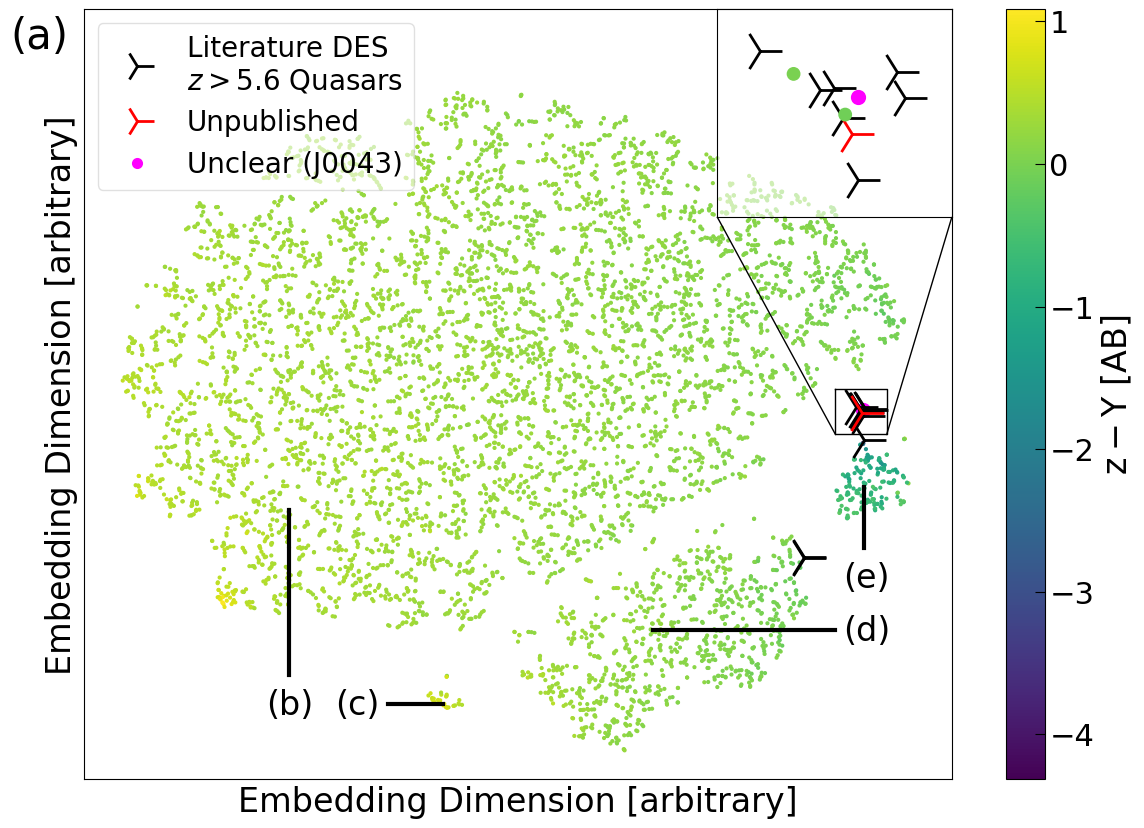

In [14]:
fg, ax = plt.subplots(figsize=(14,10))
qm='4'
J0122m='o'
cmp = cm.viridis

insax = ax.inset_axes([.73,.73,.27,.27])
ax.scatter(
    embedding[is_hzq==0,0], embedding[is_hzq==0,1],
    c=(cut_df['z_mag']-cut_df['Y_mag'])[is_hzq==0],
    cmap=cmp, s=4
)
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
for s, axis in zip([4,20],[ax, insax]):
    axis.scatter(
        embedding[is_hzq==3,0], embedding[is_hzq==3,1],
        s=80, marker=J0122m, c='magenta',  linewidths=2
    )
    axis.scatter(
        embedding[is_hzq==1,0], embedding[is_hzq==1,1],
        s=1000, marker=qm, c='k', linewidths=2
    )
    axis.scatter(
        embedding[is_hzq==2,0], embedding[is_hzq==2,1],
        s=1000, marker=qm, c='r', linewidths=2
    )
    axis.set_xticks([])
    axis.set_yticks([])
sc = insax.scatter(
    embedding[is_hzq==0,0], embedding[is_hzq==0,1],
    c=(cut_df['z_mag']-cut_df['Y_mag'])[is_hzq==0],
    cmap=cmp, s=80
)

# Box
(x0,x1,y0,y1)=(77.2,81,-6.4,-2.5)
xlims=ax.get_xlim()
ylims=ax.get_ylim()
pad=4
(x0p, x1p, y0p, y1p) = (x0-pad, x1+pad, y0-pad, y1+pad)
ax.plot([x0p,x1p,x1p,x0p,x0p],[y1p,y1p,y0p,y0p,y1p],'k',lw=1)
ax.plot([x0p,46],[y0p,46],'k',lw=1)
ax.plot([x1p,xlims[1]],[y0p,46],'k',lw=1)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# Colorbar
cbar = fg.colorbar(sc, ax=ax)
cbar.set_label(r'$\mathrm{z}-\mathrm{Y}$ [AB]')

ax.set_xlabel('Embedding Dimension [arbitrary]')
ax.set_ylabel('Embedding Dimension [arbitrary]')

insax.set_xlim(x0, x1)
insax.set_ylim(y0, y1)
insax.patch.set_alpha(0.6)

# Legend
custom_lines = [
    lines.Line2D([0],[0], marker=qm,    ms=24, color='k',lw=0,mew=2),
    lines.Line2D([0],[0], marker=qm,    ms=24, color='r',lw=0,mew=2),
    lines.Line2D([0],[0], marker=J0122m,ms=6, color='magenta',lw=0,mew=2)
]
ax.legend(
    custom_lines,
    [r"""Literature DES
$z>5.6$ Quasars""",
    r'Unpublished',
    r'Unclear (J0043)'],
    loc='upper left',
    framealpha=.6
)

for lbl, coi, text_coords, to_coords in zip(
    ['b','c','d','e'],
    [1564896813, 1618843987, 926139996, 1143606242],
    [[-58,-83], [-42,-83], [75,-64],[75,-50]],
    [['y',-73], ['x',-30], ['x',73],['y',-40]]
):
    ax.annotate(
        f'({lbl})',
        xy=text_coords
    )
    embed_point = embedding[ids==coi][0]
    if to_coords[0]=='x':
        to_point = [to_coords[1], embed_point[1]]
    else:
        to_point = [embed_point[0], to_coords[1]]
    ax.plot(
        [embed_point[0], to_point[0]],
        [embed_point[1], to_point[1]],
        c='k', lw=3
    )

ax.annotate('(a)', xy=[xlims[0]-17, ylims[1]-10], annotation_clip=False, fontsize=30)
fg.savefig('./paper/figs/latent_space.pdf', bbox_inches='tight')

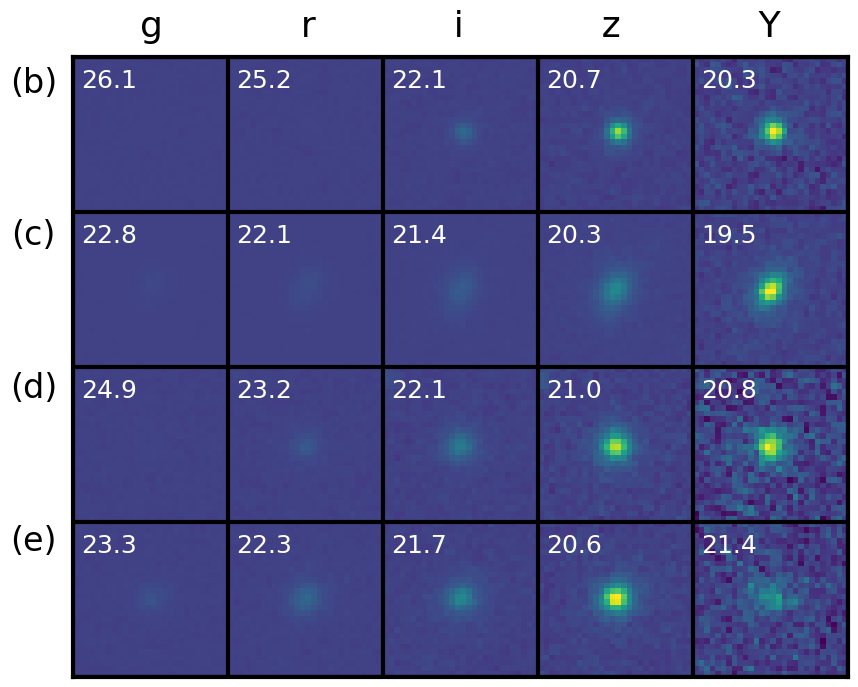

In [15]:
# eg_cois = [1358001747, 894712355, 1452522417, 1248581703, 904105229, 1097290985]
eg_cois = [1564896813, 1618843987, 926139996, 1143606242]
conc_img = np.zeros((28*4, 28*5))
for i, eg_coi in enumerate(eg_cois):
    obj_img = imgs[ids==eg_coi][0]
    for j in range(5):
        conc_img[i*28:(i+1)*28, j*28:(j+1)*28] = obj_img[:,:,j]
# Normalising
conc_img /= np.max(conc_img) # All below 1
for i in range(4):
    conc_img[i*28:(i+1)*28,:] /= np.max(conc_img[i*28:(i+1)*28,:])

fg, ax = plt.subplots(figsize=(10,12))
ax.imshow(conc_img)
# Annotating mags
for i, eg_coi in enumerate(eg_cois):
    for j, band in enumerate(['g','r','i','z','Y']):
        ax.annotate(
            f'{cut_df.loc[eg_coi][f"{band}_mag"]:.1f}',
            xy=[j*28+1,i*28+5],
            c='white', fontsize=18
        )
spacer = '            '
ax.set_title(f'g{spacer}r{spacer}i{spacer}z{spacer}Y', pad=15)
spacer = '\n'*4
ax.set_ylabel(f"(b){spacer}(c){spacer}(d){spacer}(e)\n\n",
              rotation=0,
              y=.07, labelpad=25)
# Gridding
xtix = np.linspace(0,28*5, 6)-.5
ytix = np.linspace(0,28*4,5)-.5
ax.set_xticks(xtix)
ax.set_yticks(ytix)
ax.set_xticklabels([])
ax.set_yticklabels([])
lw=3
for spn in ['top','bottom','left','right']:
    ax.spines[spn].set_linewidth(lw)
ax.grid(visible=True, c='k', lw=lw)

fg.savefig('./paper/figs/latent_examples.pdf', bbox_inches='tight')

In [47]:
from bokeh import plotting
hzq_present = [coi for coi in hzq_df.COADD_OBJECT_ID
              if coi in ids]
def plot_simple_embedding(points):
    df = pd.DataFrame(index=ids.astype(int), columns=['x','y','url'])
    df['x'] = points[:,0]
    df['y'] = points[:,1]
    df['id'] = ids.astype(int)
    df['url'] = [f'https://xbyrne.github.io/images/grizY/{idd}.png' for idd in ids]
    img_tooltip = """@{id}
                        <img src="@{url}"
                            width="500"
                            height="auto"
                          </img>"""
                        #   style="width="100"; height="1";">
    P = plotting.figure(tooltips=img_tooltip)
    P.circle('x', 'y', size=3, source=df)
    P.x('x', 'y',
        size=30,
        line_width=2,
        color='black',
        source=df.loc[hzq_present])
    # P.min_border_left=200
    P.min_border_right=200
    # P.min_border_top=100
    P.min_border_bottom=200
    # P.axis.axis_line_width = 0
    # P.axis.major_tick_line_alpha = 0
    # P.axis.minor_tick_line_alpha = 0
    # P.axis.major_label_text_alpha=0

    plotting.output_notebook()
    plotting.show(P)
    return P
P = plot_simple_embedding(embedding)

Loading BokehJS ...

The below cell is code to find some data for a table in the paper, listing details of all the quasars selected by the neural network.

## SED Fitting

In [16]:
# Images
ids = np.load('./data/processed/ids.npz')['ids'].astype(int)
imgs = np.load('./data/processed/imgs.npz')['imgs']
# Magnitudes
cut_df = pd.read_csv('./data/processed/cut_crossmatched_objects.csv', index_col=0)
band_offsets = {'g':0,'r':0,'i':0,'z':0,'Y':0,'J':0,'K':0,
                'W1':2.699,'W2':3.339}
# Filters
bands = ['g','r','i','z','Y','J','K','W1','W2']
filters = list(quasar_galaxy_fit.filters_pyphot.values())
eff_wavs = [filter.leff.value for filter in filters]
# My quasars and their names
lhzq_cois = [1143273115, 1599741416, 1695974542]
redshifts = [6.074, 5.941, 5.986]
coord_name_dict = dict(zip( lhzq_cois, [r'J0109$-$5424', r'J0603$-$3923', r'J0122$-$4609'] ))
# Colour scheme + labels
lephare_colours, lephare_labels = ['g','b','orange'], ['Galaxy','Quasar','Star']
bagpipes_colours, bagpipes_labels = ['g','b','m'], ['Galaxy','Quasar','Galaxy+Quasar']
all_cols = [lephare_colours, bagpipes_colours]
all_labels = [lephare_labels, bagpipes_labels]
# Colouring for bandpasses
band_hues = cm.rainbow( colors.Normalize(vmin=min(eff_wavs),vmax=max(eff_wavs))(eff_wavs) )
band_shade = band_hues
band_shade[:,3] = .2
band_lines = band_hues
band_lines[:,3] = .4

In [17]:
lephare_wavs, lephare_spectra = [],[]
for coi in lhzq_cois:
    (
        lephare_gw, lephare_gs, lephare_qw, lephare_qs, lephare_sw, lephare_ss
    ) = myutils.unpack_lephare_spectra(coi)

    lephare_wavs.append([lephare_gw, lephare_qw, lephare_sw])
    lephare_spectra.append([lephare_gs, lephare_qs, lephare_ss])

bagpipes_wavs, bagpipes_spectra = [],[]
for coi, z in zip(lhzq_cois, redshifts):
    thisobj_bagpipes_wavs, thisobj_bagpipes_spectra = [],[]
    for model_type in ['G','Q','GQ']:
        wavs, spec = quasar_galaxy_fit.spectrum_from_params(
            myutils.find_best_model(coi, model_type), z_QSO=z
        )
        spec *= 1e6 # Jy -> uJy
        thisobj_bagpipes_wavs.append(wavs)
        thisobj_bagpipes_spectra.append(spec)
    bagpipes_wavs.append(thisobj_bagpipes_wavs)
    bagpipes_spectra.append(thisobj_bagpipes_spectra)

/data/ajnb3/my_conda/envs/qso/lib/python3.11/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/data/ajnb3/my_conda/envs/qso/lib/python3.11/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


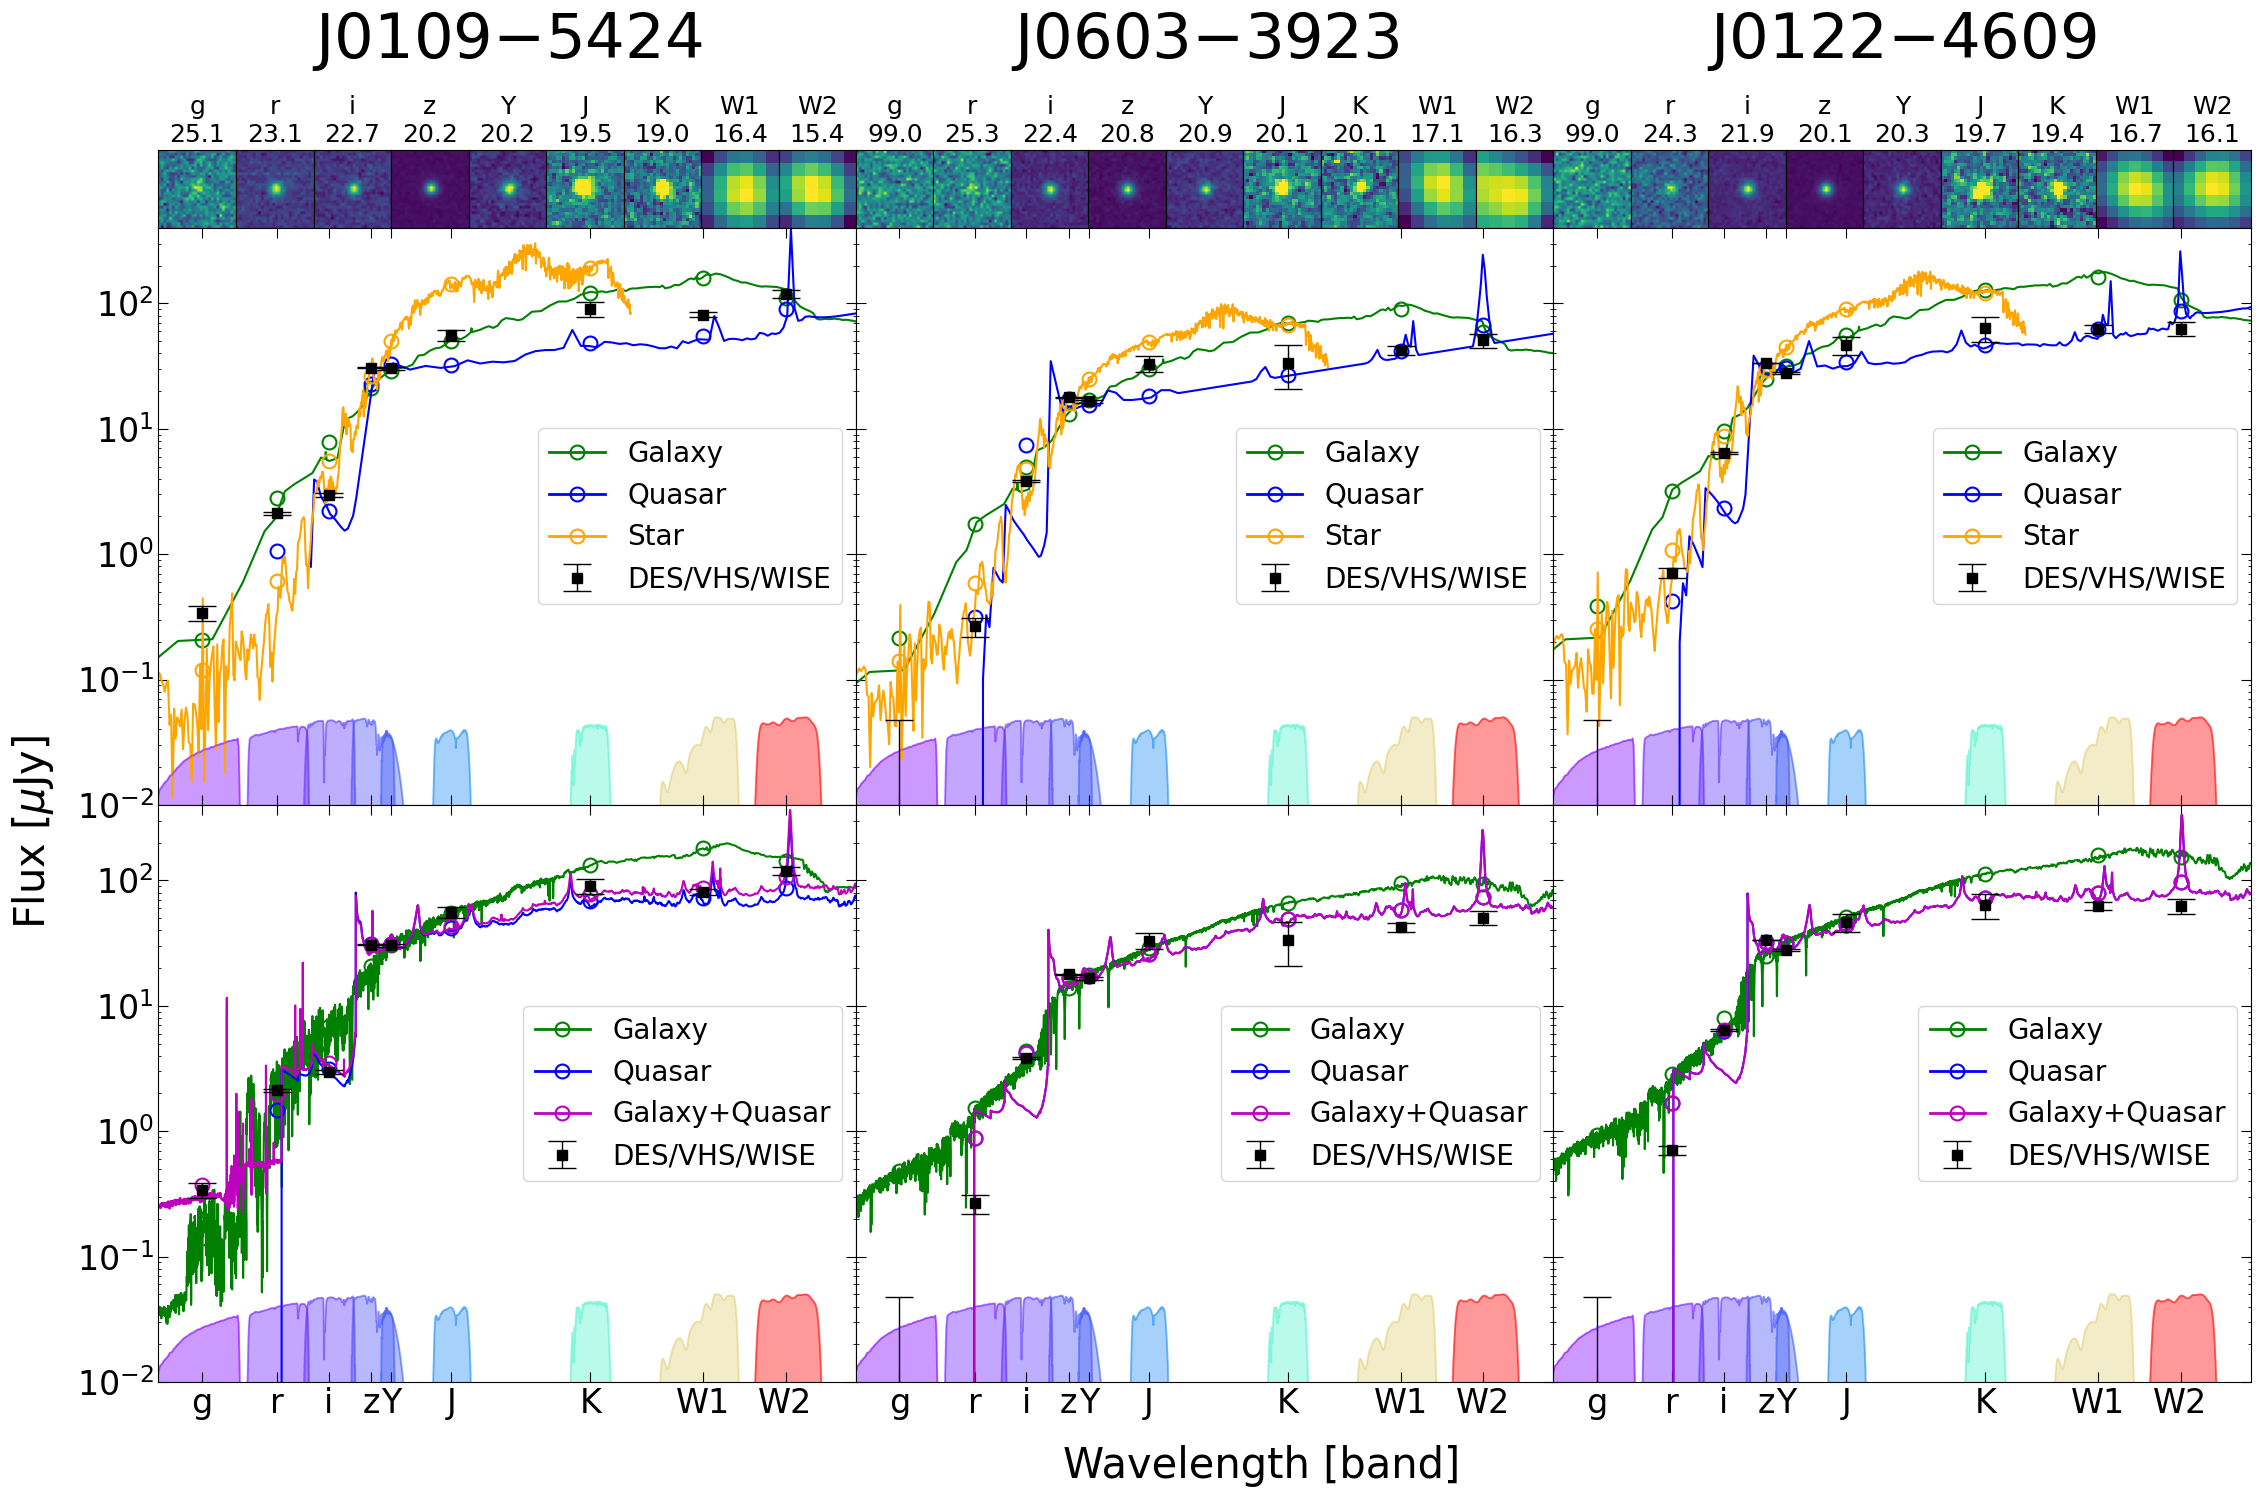

In [19]:
fg, axs = plt.subplot_mosaic(
    [
        [f'{band}0' for band in bands] + [f'{band}1' for band in bands] + [f'{band}2' for band in bands],
        ['LePHARE0'] * 9 + ['LePHARE1'] * 9 + ['LePHARE2'] * 9,
        ['BAGPIPES0']* 9 + ['BAGPIPES1']* 9 + ['BAGPIPES2']* 9
    ],
    figsize=(27,16),
    height_ratios=[.54,4,4],
    gridspec_kw={'hspace':0,'wspace':0}
)
for i, coi in enumerate(lhzq_cois):
    ## Imaging
    for j, band in enumerate(bands[:5]):
        axs[f'{band}{i}'].imshow(imgs[ids==coi][0][:,:,j])
    for band in ['J','K']:
        axs[f'{band}{i}'].imshow(255-plt.imread(f'./paper/figs/{coi}_{band}.jpg'))
    for band in ['W1','W2']:
        axs[f'{band}{i}'].imshow(fits.open(f'./paper/figs/{coi}_{band}.fits')[0].data)
    object_magnitudes = cut_df.loc[coi]
    for band in bands:
        ax = axs[f'{band}{i}'] # Axes showing imaging
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title( # Writing magnitudes on top of imaging
            f'{band}\n{object_magnitudes[f"{band}_mag"] - band_offsets[band]:.1f}',
            fontsize=18
        )
    
    ## Spectra plots
    # Sorting spectra
    thisobj_axes = [axs[f'LePHARE{i}'], axs[f'BAGPIPES{i}']]
    thisobj_wavs = [lephare_wavs[i], bagpipes_wavs[i]]
    thisobj_spectra = [lephare_spectra[i], bagpipes_spectra[i]]
    # Plotting
    for ax, wavset, specset, colset, lblset in zip( # LePHARE and BAGPIPES
        thisobj_axes, thisobj_wavs, thisobj_spectra, all_cols, all_labels
    ):
        # Adding spectra
        for wavs, spectrum, col in zip(
            wavset, specset, colset
        ):
            ax.plot(wavs, spectrum, c=col)
            ax.plot(
                eff_wavs, quasar_galaxy_fit.spectrum_to_photometry(wavs, spectrum),
                marker='o', mec=col, mew=1.5, mfc='None', lw=0, ms=10,
                label='_nolegend_'
            )
        # Adding DES/WISE/VHS fluxes
        true_fluxes = ax.errorbar(
            eff_wavs, object_magnitudes[[f'{band}_flux' for band in bands]],
            yerr = object_magnitudes[[f'{band}_fluxerr' for band in bands]],
            marker='s', mfc='k', mec='k', ms=7, lw=0,
            ecolor='k', elinewidth=1, capsize=10,
            label='DES/VHS/WISE'
        )
        # Adding filter bandpasses
        factor=5e-2
        for filter, shade_col, line_col in zip(filters, band_shade, band_lines):
            ax.fill_between(
                filter.wavelength.value, filter.transmit*factor,
                color=shade_col, label='_nolegend_'
            )
            ax.plot(
                filter.wavelength.value, filter.transmit*factor,
                c=line_col, label='_nolegend_'
            )
        # Axis design
        ax.set_xlim(4e3,6e4)
        ax.set_ylim(1e-2,4e2)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks(eff_wavs)
        ax.set_xticks([], minor=True)
        # Legend
        legend_elements = [lines.Line2D(
            [0],[0], color=col, lw=2,
            marker='o', mfc='None', mec=col, ms=10, mew=1.5,
            label=lbl
        ) for col, lbl in zip(colset, lblset)]\
        + [true_fluxes]
        ax.legend(handles=legend_elements)

    # Titles and ticks
    axs[f'LePHARE{i}'].set_xticklabels([])
    axs[f'LePHARE{i}'].set_title(
        coord_name_dict[coi], y=1.28, fontsize=45
    )
    axs[f'BAGPIPES{i}'].set_xticklabels(bands, fontsize=24)
    for ax in axs[f'LePHARE{i}'], axs[f'BAGPIPES{i}']:
        if i>0:
            ax.set_yticklabels([])
        else:
            ax.tick_params(axis='y', labelsize=24)
        
fg.text(0.07, .4, f'Flux [$\mu$Jy]', rotation='vertical', fontsize=30)
fg.text(0.46, 0.05, 'Wavelength [band]', fontsize=30)
fg.set_rasterized(True)
# fg.tight_layout()
fg.savefig(f'./paper/figs/seds.pdf', bbox_inches='tight', pad_inches=0.1)

16


/data/ajnb3/my_conda/envs/qso/lib/python3.11/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/data/ajnb3/my_conda/envs/qso/lib/python3.11/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


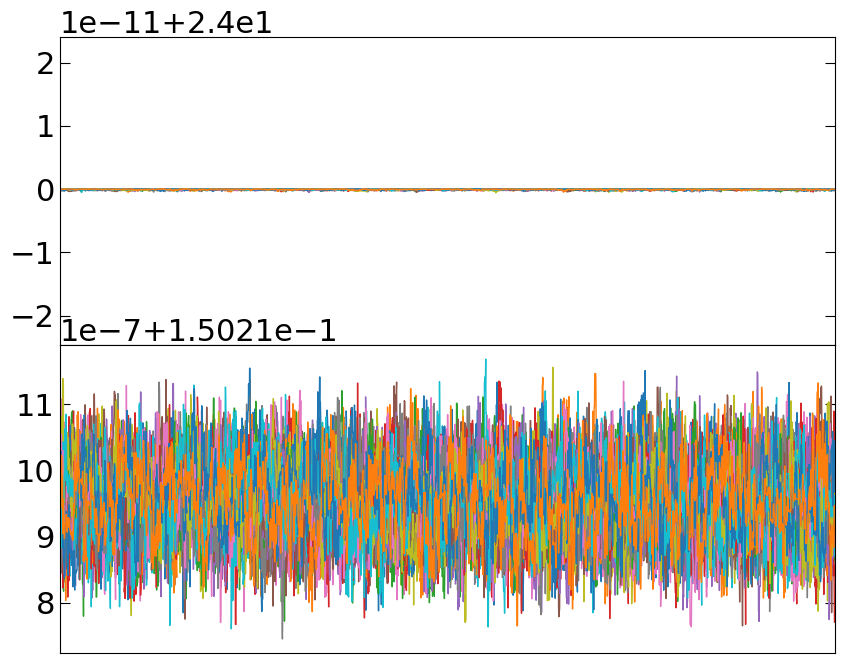

In [41]:
coi = lhzq_cois[0]
# Best mcmc quasar model
samples = np.load(f'./data/sed_fitting/mcmc_results/Q/{coi}.npz')['samples']
n = samples.shape[-1]
fg, axs = plt.subplots(n, 1, figsize=(10,8), gridspec_kw={'hspace':0})
for ax, smp in zip(axs, np.rollaxis(samples, 2)):
    ax.plot(np.arange(3000), smp, lw=1)
    ax.set_xticks([])
    ax.set_xlim(0,3000)

In [70]:
coi = lhzq_cois[2]
# BAGPIPES spectra
bagpipes_spectra = []
bagpipes_wavs = []
for model_type in ['G','Q','GQ']:
    fl = np.load(f'./data/sed_fitting/mcmc_results/{model_type}/{coi}.npz')
    samples = fl['samples']
    samples = samples.reshape(
        np.product(samples.shape[:2]), samples.shape[-1]
    )
    best_fit_model = samples[fl['logprobs'].argmax()]
    wavs, spectrum = myutils.spectrum_from_params(best_fit_model)
    bagpipes_spectra.append(spectrum)
    bagpipes_wavs.append(wavs)

# LePHARE spectra
lephare_filename = f'./lephare/lephare_dev/output_spectra/Id{str(coi)[-9:]}.spec'
(
    galaxy_wavs, galaxy_spectrum,
    quasar_wavs, quasar_spectrum,
    stellar_wavs,stellar_spectrum,
) = myutils.unpack_lephare_spectra(lephare_filename)
lephare_wavs = [galaxy_wavs, quasar_wavs, stellar_wavs]
lephare_spectra = [galaxy_spectrum, quasar_spectrum, stellar_spectrum]

# BEGIN FIGURE
fg, axs = plt.subplot_mosaic(
    [
        bands,
        ['LePHARE']*9,
        ['BAGPIPES']*9
    ],
    figsize=(9,12),
    height_ratios=[.75,4,4],
    gridspec_kw={'hspace':0,'wspace':0}
)
# fg.subplots_adjust(hspace=0, wspace=0)

# IMAGING
for i, band in enumerate(['g','r','i','z','Y']):
    axs[band].imshow(imgs[ids==coi][0][:,:,i])
for band in ['J','K']:
    axs[band].imshow(255-plt.imread(
        f'./figs/{coi}_{band}.jpg'
    ))
for band in ['W1','W2']:
    axs[band].imshow(
        fits.open(f'./figs/{coi}_{band}.fits')[0].data
    )
object_magnitudes = cut_df.loc[coi]
for band in bands:
    ax = axs[band]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(
        f'{band}\n{object_magnitudes[f"{band}_mag"] - band_offsets[band] : .1f}',
        fontsize=18
    )

# PLOTTING MODELS
## LePHARE
ax = axs['LePHARE']
for i, (col, lbl, wavs, spectrum) in enumerate(zip(
    lephare_colours, lephare_labels, lephare_wavs, lephare_spectra
)):
    ax.plot(
        wavs, spectrum, c=col
    )
    ax.plot(
        eff_wavs, myutils.spectrum_to_photometry(wavs, spectrum),
        c=col, marker='o', mec=col, mew=1.5, mfc='None', lw=0, ms=10,
        label='_nolegend_'
    )

ax = axs['BAGPIPES']
for i, (col, lbl) in enumerate(zip(bagpipes_colours, bagpipes_labels)):
    spectrum = bagpipes_spectra[i]
    wavs_bagpipes = bagpipes_wavs[i]
    ax.plot(
        wavs_bagpipes, spectrum, c=col
    )
    ax.plot(
        eff_wavs, myutils.spectrum_to_photometry(wavs_bagpipes, spectrum),
        c=col, marker='o', mec=col, mew=1.5, mfc='None', lw=0, ms=10,
        label='_nolegend_'
    )

factor=5e-2
ymax=100

for ax, cols, lbls in zip(
    [axs['LePHARE'], axs['BAGPIPES']],
    [lephare_colours, bagpipes_colours],
    [lephare_labels, bagpipes_labels]
):
    for filter, shade_col, line_col in zip(
        filters, band_shade, band_lines
    ):
        ax.fill_between(
            filter.wavelength.value,
            filter.transmit*factor,
            color=shade_col,
            label='_nolegend_'
        )
        ax.plot(
            filter.wavelength.value, filter.transmit*factor,
            c=line_col,
            label='_nolegend_'
        )

    true_fluxes = ax.errorbar(
        eff_wavs, object_magnitudes[[f'{band}_flux' for band in bands]],
        yerr = object_magnitudes[[f'{band}_fluxerr' for band in bands]],
        marker='s', mfc='k', mec='k', ms=7, lw=0,
        ecolor='k', elinewidth=1, capsize=10,
        label='DES/VHS/WISE'
    )
    # Legend
    legend_elements = [
        lines.Line2D(
            [0],[0], color=cols[j], lw=2,
            marker='o', mfc='None', mec=cols[j], ms=10, mew=1.5,
            label=lbls[j]
        ) for j in range(3)
    ]+[true_fluxes]
    ax.legend(handles = legend_elements, loc='center right')

    ax.set_xlim([4e3,6e4])
    ax.set_xscale('log')
    ax.set_xticks(eff_wavs)
    ax.set_xticklabels(bands)
    ax.tick_params(which='minor', length=0)
    ax.set_yscale('log')
    # ax.set_ylim([0,ymax])
    ax.set_ylim([5e-3,5e2])
    # if coi==lhzq_cois[0]:
    ax.set_ylabel(f'Flux [$\mu$Jy]')
    # else:
    #     ax.set_yticklabels([])
    ax.set_xlabel('Wavelength')

fg.suptitle(coord_name_dict[coi], x=.6, y=.96)
fg.set_rasterized(True)
fg.tight_layout()
fg.savefig(f'./figs/{coord_name_dict[coi][:5]}_sed.eps', format='eps')

/data/ajnb3/my_conda/envs/qso/lib/python3.11/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/data/ajnb3/my_conda/envs/qso/lib/python3.11/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


FileNotFoundError: ./lephare/lephare_dev/output_spectra/Id4542.spec.spec not found.

Text(0.5, 1.0, '$z=5.944\\pm0.006$')

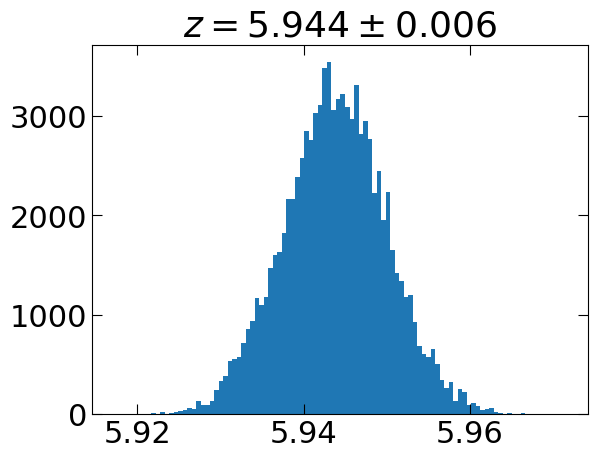

In [55]:
# Calculating photometric redshifts
lhzq_cois = [1143273115, 1599741416]
arch_cois = [1621863463, 1695974542]
coi = lhzq_cois[1]
fl = np.load(f'./data/sed_fitting/mcmc_results/GQ/{coi}.npz')
redshift_samples = fl['samples'][:,:,-1].ravel()
redshift_samples = redshift_samples[redshift_samples<6.]
plt.hist(np.ravel(redshift_samples), bins=100);
plt.title(rf'$z={np.mean(redshift_samples):.3f}\pm{np.std(redshift_samples):.3f}$')

In [57]:
# Calculating BICs
lhzq_cois = [1143273115, 1599741416]
arch_cois = [1621863463, 1695974542]
coi = lhzq_cois[1]
def calc_BIC(coi, model_type):
    k = {'G':6,'Q':2,'GQ':8}[model_type]
    fl = np.load(f'./data/sed_fitting/mcmc_results/{model_type}/{coi}.npz')
    BIC = k * np.log(9) - 2*np.max(fl['logprobs'])
    return BIC
print(calc_BIC(coi, 'GQ'))

18.105998653622343


In [59]:
quasar_ids = np.load('./data/processed/quasar_ids.npz')['ids']
BICs = np.zeros((len(quasar_ids), 3))
for i, coi in enumerate(quasar_ids):
    BICs[i,0] = calc_BIC(coi, 'G')
    BICs[i,1] = calc_BIC(coi, 'Q')
    BICs[i,2] = calc_BIC(coi, 'GQ')

C:\Users\byrne\AppData\Local\Temp\ipykernel_13120\133326238.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(BICs[:,1] - BICs[:,2])


Text(0, 0.5, '$log \\Delta$BIC')

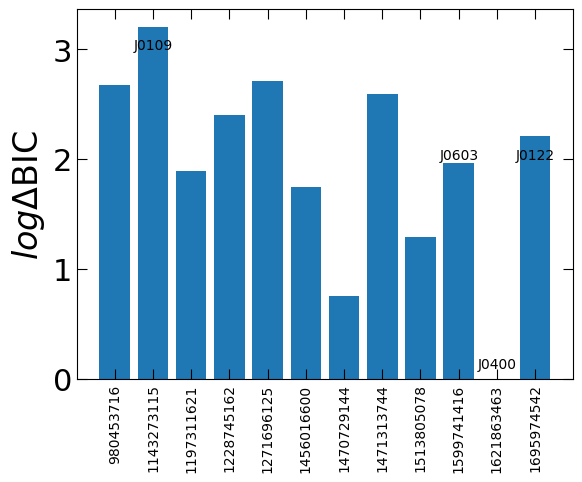

In [74]:
fg, ax = plt.subplots()
ax.bar(
    range(len(quasar_ids)),
    np.log10(BICs[:,1] - BICs[:,2])
)
ax.set_xticks(range(len(quasar_ids)))
ax.set_xticklabels(quasar_ids, fontsize=10, rotation=90);
ax.annotate('J0109', [.5,3], fontsize=10)
ax.annotate('J0603', [8.5,2], fontsize=10)
ax.annotate('J0400', [9.5,0.1], fontsize=10)
ax.annotate('J0122', [10.5,2], fontsize=10)
ax.set_ylabel(r'$log \Delta$BIC')

In [70]:
dBICs = BICs[:,2] - BICs[:,1]
dBICs

array([ -477.72187212, -1605.69733657,   -77.59287585,  -254.93512225,
        -518.20181372,   -55.77842351,    -5.62844065,  -388.64090448,
         -19.3802646 ,   -91.47027772,     2.53937668,  -162.16466445])